In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import least_squares

#### FLu Data Importing and Munging
[Influenza Laboratory-Confirmed Cases](https://health.data.ny.gov/Health/Influenza-Laboratory-Confirmed-Cases-By-County-Beg/jr8b-6gh6/)

In [2]:
Flu_Raw = pd.read_csv('data/Flu_1216.csv')

Flu_Raw['Week Ending Date'] =  pd.to_datetime(Flu_Raw['Week Ending Date'], format="%m/%d/%Y")
Flu_Sort = Flu_Raw.sort_values(by='Week Ending Date', ignore_index=True, ascending= False)
szn_ls = ['2022-2023', '2021-2022', '2020-2021', '2019-2020', '2018-2019','2017-2018']
Flu_Sort = Flu_Sort[(Flu_Sort.Region=='NYC')&(Flu_Sort.Season.isin(szn_ls))&(Flu_Sort.Disease=='INFLUENZA_A')]

Flu_Disease = Flu_Sort[['Week Ending Date','CDC Week','Disease', 'Count']]
Flu_Disease = Flu_Disease.reset_index(drop=True)
Flu_Disease = Flu_Disease.groupby('Week Ending Date').sum()
Flu_Disease["CDC Week"] = Flu_Disease["CDC Week"]/5

week_1718 = [i for i in range(len(Flu_Disease.iloc[:33,0]))]
count_1718 = Flu_Disease.iloc[:33,1]

week_1819 = [i for i in range(len(Flu_Disease.iloc[33:66,0]))]
count_1819 = Flu_Disease.iloc[33:66,1]

week_1920 = [i for i in range(len(Flu_Disease.iloc[66:94,0]))]
count_1920 = Flu_Disease.iloc[66:94:,1]

week_2021 = [i for i in range(len(Flu_Disease.iloc[94:128,0]))]
count_2021 = Flu_Disease.iloc[94:128,1]

week_2122 = [i for i in range(len(Flu_Disease.iloc[128:166,0]))]
count_2122 = Flu_Disease.iloc[128:166,1]

week_2223 = [i for i in range(len(Flu_Disease.iloc[166:,0]))] 
count_2223 = Flu_Disease.iloc[166:,1]

# fig, ax = plt.subplots(1,1) 
# x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
# ax.set_xticks(np.arange(0,30,4))
# ax.set_xticklabels(x_ticks_labels)
# ax.plot(week_1718, count_1718, label = "2017-18", c='black')
# ax.plot(week_1819, count_1819, label = "2018-19")
# ax.plot(week_1920, count_1920, label = "2019-20")
# ax.plot(week_2021, count_2021, label = "2020-21")
# ax.plot(week_2122, count_2122, label = "2021-22")
# ax.plot(week_2223, count_2223, label = "2022-23")
# ax.set_xlabel('Month')
# ax.set_ylabel('Number of Influenza A Cases')
# ax.set_title('2022-2023 Season Simulation')
# plt.legend()
# plt.show()
# # fig.savefig('Flu_23.svg', format='svg', dpi=1200)

#### Curve_fit

In [3]:
from scipy.optimize import curve_fit

In [4]:
N = 8468000
T = 63
dt = 7
Nt = np.int(T/dt)+1
t = np.linspace(0, T, Nt)
whole_t = np.linspace(0,238,np.int(238/7)+1)
a0 = .2
b0 = .11

In [5]:
# The SIR model differential equations.
def SIRdot(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N - 0.005*0.5*S
    dIdt = a * S * I/N  - b * I
    dRdt = b * I + 0.005*0.5*S
    # dVdt = 0.005*0.5*S 
    return dSdt, dIdt, dRdt#, dVdt
def SIR(t,N,a,b):
    Y0 = N-290-0, 290, 0

    # Integrate the equations over the time grid, t.
    ret = odeint(SIRdot, Y0, t, args=(N,a,b))
    S,I,R= ret.T
    return I

In [6]:
def SIR_All(t,N,a,b):
    Y0 = N-290-0, 290, 0

    # Integrate the equations over the time grid, t.
    ret = odeint(SIRdot, Y0, t, args=(N,a,b))
    S,I,R = ret.T
    return S, I, R

In [7]:
def SIRdotH(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N - 0.008*0.5*S
    dIdt = a * S * I/N  - b * I
    dRdt = b * I + 0.008*0.5*S
    # dVdt = 0.005*0.5*S 
    return dSdt, dIdt, dRdt#, dVdt
def SIRH(t,N,a,b):
    Y0 = N-290-0, 290, 0

    # Integrate the equations over the time grid, t.
    ret = odeint(SIRdotH, Y0, t, args=(N,a,b))
    S,I,R= ret.T
    return S, I, R

In [8]:
def SIRdotL(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N - 0.001*0.5*S
    dIdt = a * S * I/N  - b * I
    dRdt = b * I + 0.001*0.5*S
    return dSdt, dIdt, dRdt
def SIRL(t,N,a,b):
    Y0 = N-290-0, 290, 0

    # Integrate the equations over the time grid, t.
    ret = odeint(SIRdotL, Y0, t, args=(N,a,b))
    S,I,R= ret.T
    return S, I, R

In [9]:
params, pcov = curve_fit(SIR, t,count_2223, p0 = [N-290, a0, b0], bounds = ([(N-290)/100, 0.0, .05], [3*(N-290), 5.0, .2]) )
N_curve,a,b = params
Re0 = (a*(8468000-290))/(b*8468000)
N_curve, a, b, Re0 

(1891019.052635727,
 0.27752313806439777,
 0.18695182863928259,
 1.4844125134651356)

In [10]:
res_S, res_I, res_R = SIR_All(whole_t,N_curve,a,b)

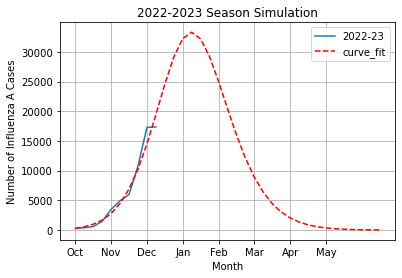

In [12]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.plot(week_2223, count_2223, label = "2022-23")
ax.set_xlabel('Month')
ax.set_ylabel('Number of Influenza A Cases')
ax.set_title('2022-2023 Season Simulation')
ax.plot([i for i in range(len(res_I))], res_I, label = 'curve_fit', linestyle='dashed', c='red')
# ax.plot([i for i in range(len(res_Ia))], res_Ia, label = 'average', linestyle='dashdot')
ax.grid()
plt.legend()
plt.show()
fig.savefig('Flu_23.svg', format='svg', dpi=1200)

##### comparsion between different vaccination rate $v$

In [13]:
res_SH, res_IH, res_RH = SIRH(whole_t,N_curve,a,b)
res_SL, res_IL, res_RL = SIRL(whole_t,N_curve,a,b)

In [14]:
res_IH.max(), res_IL.max(), res_I.max()

(12167.38292700468, 94065.95628264238, 33292.29910194211)

In [21]:
list(res_IH).index(res_IH.max()), list(res_I).index(res_I.max()), list(res_IL).index(res_IL.max())

(12, 13, 12)

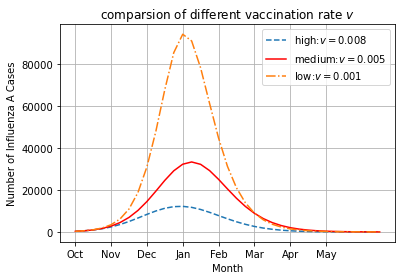

In [22]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Influenza A Cases')
ax.set_title('comparsion of different vaccination rate $v$')
ax.plot([i for i in range(len(res_IH))], res_IH, linestyle='dashed', label = 'high:$v=0.008$')
ax.plot([i for i in range(len(res_I))], res_I, label = 'medium:$v=0.005$', c='red')
ax.plot([i for i in range(len(res_IL))], res_IL, linestyle='dashdot', label = 'low:$v=0.001$')
ax.grid()
plt.legend()
plt.show()
fig.savefig('different_v.svg', format='svg', dpi=1200)

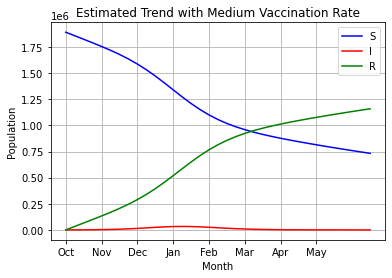

In [16]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.plot([i for i in range(len(res_S))], res_S, label = 'S',  c='blue')
ax.plot([i for i in range(len(res_I))], res_I, label = 'I',  c='red')
ax.plot([i for i in range(len(res_R))], res_R, label = 'R',  c='green')
ax.set_xlabel('Month')
ax.set_ylabel('Population')
ax.set_title('Estimated Trend with Medium Vaccination Rate')
ax.grid()
plt.legend()
plt.show()
fig.savefig('med.svg', format='svg', dpi=1200)

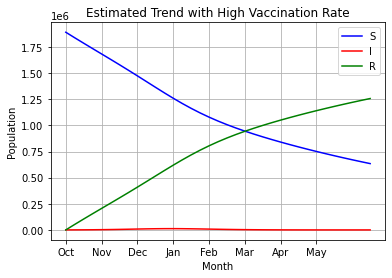

In [17]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.plot([i for i in range(len(res_SH))], res_SH, label = 'S',  c='blue')
ax.plot([i for i in range(len(res_IH))], res_IH, label = 'I',  c='red')
ax.plot([i for i in range(len(res_RH))], res_RH, label = 'R',  c='green')
ax.set_xlabel('Month')
ax.set_ylabel('Population')
ax.set_title('Estimated Trend with High Vaccination Rate')
ax.grid()
plt.legend()
plt.show()
fig.savefig('high.svg', format='svg', dpi=1200)

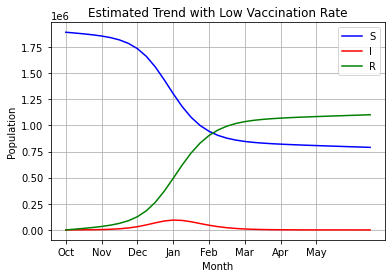

In [18]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.plot([i for i in range(len(res_SL))], res_SL, label = 'S',  c='blue')
ax.plot([i for i in range(len(res_IL))], res_IL, label = 'I',  c='red')
ax.plot([i for i in range(len(res_RL))], res_RL, label = 'R',  c='green')
ax.set_xlabel('Month')
ax.set_ylabel('Population')
ax.set_title('Estimated Trend with Low Vaccination Rate')
ax.grid()
plt.legend()
plt.show()
fig.savefig('low.svg', format='svg', dpi=1200)

In [19]:
def MSE(y, y_hat):
    return np.square(np.subtract(y,y_hat)).mean()
Curve_MSE = MSE(count_2223,res_I[:len(t)])
np.sqrt(Curve_MSE)

1187.2612916683122